# Lab - Decision Tree & Random Forest
In this lab, we will apply Tree-based models to the California Housing dataset. We will explore:
1. **Decision Trees**: Single tree construction, visualization, and pruning.
2. **Random Forests**: Ensemble learning with Bagging and OOB evaluation.
3. **Feature Importance**: Interpreting what the model learned.

## 1. Introduction & Setup
In this section, we load the [California housing dataset](https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_california_housing.html) and perform initial exploration.

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

# Load the dataset
housing = fetch_california_housing(as_frame=True)
df = housing.frame.copy()

# Basic Info
print(housing.DESCR.split('\n')[0:10]) # Print first few lines of description
print(f"Shape: {df.shape}")

['.. _california_housing_dataset:', '', 'California Housing dataset', '--------------------------', '', '**Data Set Characteristics:**', '', ':Number of Instances: 20640', '', ':Number of Attributes: 8 numeric, predictive attributes and the target']
Shape: (20640, 9)


## 2. Visualization
Before modeling, we must understand the feature distributions and correlations.

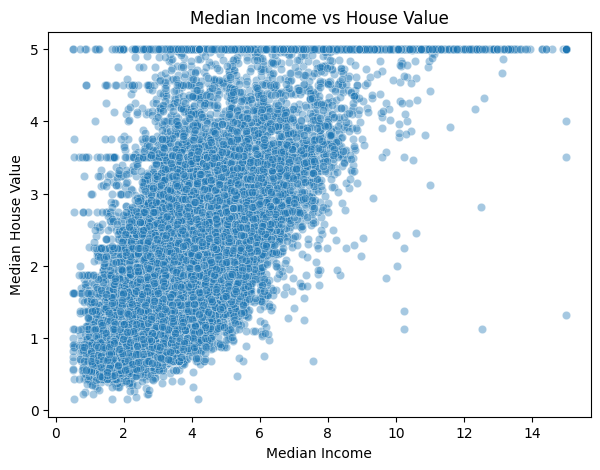

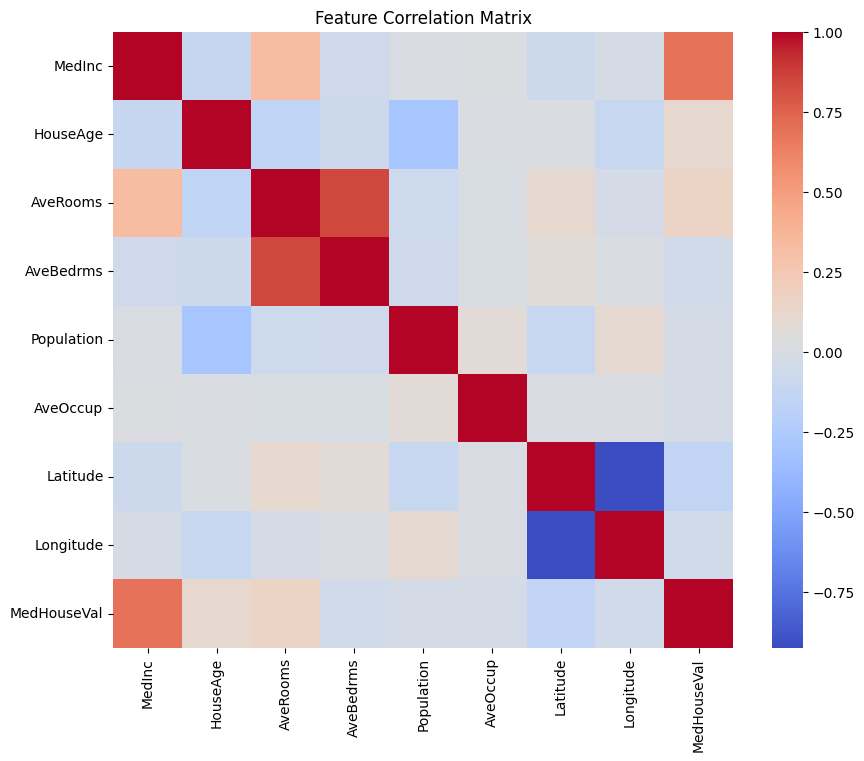

In [19]:
# Visualize interesting features, e.g., Median Income vs Price
import seaborn as sns
plt.figure(figsize=(7,5))
sns.scatterplot(x=df['MedInc'], y=df['MedHouseVal'], alpha=0.4)
plt.xlabel('Median Income')
plt.ylabel('Median House Value')
plt.title('Median Income vs House Value')
plt.show()

# Quick correlation heatmap for feature overview
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

## 3. Data preprocessing
Note: Unlike KNN or Linear Models, Trees do not strictly require feature scaling. You can try to scale the data and see if there are differences.

In [20]:
# Prepare data for training
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Features and target
X = df.drop(columns='MedHouseVal')
y = df['MedHouseVal']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convenience DataFrames (optional)
X_train_s = pd.DataFrame(X_train, columns=X.columns, index=X_train.index)
X_test_s = pd.DataFrame(X_test, columns=X.columns, index=X_test.index)
X_train_s.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
14196,3.2596,33.0,5.017657,1.006421,2300.0,3.691814,32.71,-117.03
8267,3.8125,49.0,4.473545,1.041005,1314.0,1.738095,33.77,-118.16
17445,4.1563,4.0,5.645833,0.985119,915.0,2.723214,34.66,-120.48
14265,1.9425,36.0,4.002817,1.033803,1418.0,3.994366,32.69,-117.11
2271,3.5542,43.0,6.268421,1.134211,874.0,2.300000,36.78,-119.80


## 4. Decision Tree
We will start with a single **Decision Tree Regressor**. 
As discussed in the lecture, decision trees split data based on feature values to reduce node impurity (Variance/MSE for regression).

We will verify the impact of **Pruning** (controlling tree complexity) by setting `max_depth`.

In [ ]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# 1. Train a "Pre-pruned" Tree to avoid overfitting (Lecture Slide 31)
# We limit max_depth to keep the model interpretable and reduce variance

decision_tree = DecisionTreeRegressor(random_state=0, max_depth=2)
decision_tree.fit(X_train, y_train)

# Make predictions
y_train_pred = decision_tree.predict(X_train)
y_test_pred = decision_tree.predict(X_test)

# Evaluate
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Decision Tree Performance:")
print(f"Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")
print(f"Train R²: {train_r2:.4f} | Test R²: {test_r2:.4f}")


# 2. Visualize the Tree (Lecture Slide 29)

plt.figure(figsize = (20, 10))
plot_tree(decision_tree, filled=True, feature_names=X.columns, rounded=True, fontsize=12)
plt.savefig('housing.png', format='png') # save plot to .png
plt.show()

Decision Tree Performance:
Train RMSE: 0.0000 | Test RMSE: 0.7077
Train R²: 1.0000 | Test R²: 0.6178


KeyboardInterrupt: 

## 5. Random Forest (Bagging)
A single tree often suffers from high variance (overfitting). As per the lecture, **Random Forest** improves generalization by creating a "forest" of trees using:
* **Row Bagging**: Bootstrapped subsets of data.
* **Feature Bagging**: Random subsets of features at each split.

We will also calculate the **Out-of-Bag (OOB) Score** (Lecture Slide 53), which acts as a built-in validation metric.

In [22]:
from sklearn.ensemble import RandomForestRegressor

# Initialize Random Forest
# n_estimators: Number of trees in the forest (Lecture Slide 50)
# oob_score: Use samples not selected for training to validate (Lecture Slide 54)


# Predictions


## 6. Feature Importance
One major advantage of Tree-based models is interpretability regarding which features matter most.
We calculate importance by checking how much splitting on a feature reduces impurity across all trees (Lecture Slide 55).

In [23]:
# Calculate feature importances (Lecture Slide 56)


# Create plot


# Display top 3 features


## 7. Evaluation

In [24]:
# Compare Single Tree vs Random Forest
